## PREDICCIÓN DE LA RECUPERACIÓN METALÚRGICA MEDIANTE UN MODELO DE CÓPULA NO PARAMÉTRICO

#### Heber Hernández G., Martin Díaz V.

La **recuperación metalúrgica** representa el porcentaje de mineral valioso recuperado en un proceso de conminución y procesamiento en la industria minera, reflejando la eficiencia en la extracción y concentración del mineral. Es fundamental para evaluar la viabilidad económica de un proyecto minero, ya que una mayor recuperación implica mayores ingresos y beneficios económicos.

$$Beneficio = (Ley*\cdot \color{red}{Recuperación}*Tonelaje*Precio)-Costos$$

- **Nota:** La recuperación metalúrgica es una variable númerica continua con rango entre 0 y 100. 

**PROBLEMA:**

-   La recuperación metalúrgica obtenida por pruebas de flotación comúnmente es altamente heterotópica con respecto a otras mediciones del deposito mineral (geoquímica). 

-   La recuperación metalúrgica es una variable no aditiva, por lo que no puede estimarse directamente con técnicas geoestadísticas como el Kriging.

-   La recuperación metalúrgica normalmente tiene relaciones no lineales con la geoquímica. En dicho caso la co-estimación geoestadística no es un enfoque aplicable de forma directa. 

**ALTERNATIVA:**

    
-   Las copulas no requieren de un tipo de correlación en particular, son aplicables tanto a correlaciones altas como también bajas.
-   Es un enfoque de regresión basado en la co-dependencia, práctico, evita hipotesis complejas y es sencillo de implementar.

**OBJETIVO:** 

- Analizar la pertinencia de un modelo de cópula no paramétrica en la representación de la dependencia no lineal (ó compleja) entre dos variables; Recuperación Metalúrgica y Ley o grado mineral.

**DATOS:** 

- Se tiene información sobre la concentración de cobre a nivel porcentual (%) y la recuperación metalúrgica en un banco de minería a cielo abierto a nivel detallada, obtenida desde los registros de pozos de tronadura.

- Para evaluar el modelo propuesto, se construye una base de dato hipotética, heterotópica y sub muestreando la recuperación metalúrgica, buscando representar la forma en la que los datos se disponen antes de la explotación minera. 

- **Z2** = Variable secundaria (independiente) mayormente muestreada: Ley o grado mineral (medida en %).
- **Z1** = Variable primaria ***artificial*** (dependiente) menormente muestreada: Recuperación metalurgica (medida en %). 

**RESULTADOS:**

- Al comparar los datos reales de recuperación metalúrgica (desconocidos en el caso aplicado) versus los generados por el modelo de copula, resulta en un error de: "________________". 

In [44]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import openturns as ot
import openturns.viewer as otv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from mpl_toolkits.mplot3d import Axes3D
import warnings
import scipy.stats
import funciones_martin 
warnings.filterwarnings("ignore")

**1. Importar y transformar datos:** 

In [141]:
df = pd.read_csv("barrenos_banco.csv", sep=";")
scaler = StandardScaler()
# Las coordenadas y el grado mineral (Z2) se transformaran por cuestiones de confidencialidad en los datos. 
df[['X', 'Y']] = scaler.fit_transform(df[['X', 'Y']])
df["Z2"] = df["Z2"]*2.99 
df = df[df["Z2"] <= 3] #se eliminan "valores atipicos".
df.head(1)

,LONG,X,Y,Z2
0,14.6,1.285531,2.404668,0.43953


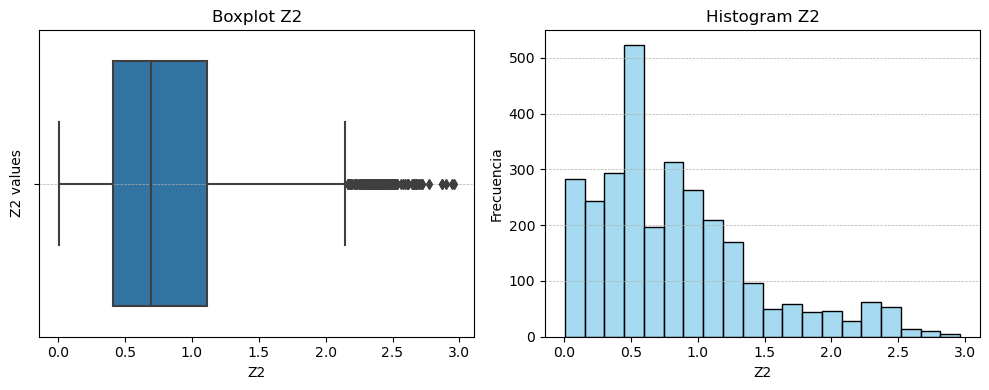

In [142]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
sns.boxplot(x=df["Z2"].dropna(), ax=axs[0])
axs[0].set_title('Boxplot Z2')
axs[0].set_ylabel('Z2 values')
axs[0].grid(axis='y', linestyle='--', linewidth=0.5)
sns.histplot(df["Z2"].dropna(), bins=20, color='skyblue', edgecolor='black', ax=axs[1])
axs[1].set_title('Histogram Z2')
axs[1].set_xlabel('Z2')
axs[1].set_ylabel('Frecuencia')
axs[1].grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

**2. Construcción de Z1 (no lineal con respecto a Z2):**

In [143]:
df['Z1_C'] = 1 - (df['Z2'] - 1.2)**2 + np.random.normal(0, 0.2, len(df))
Z1_C = MinMaxScaler(feature_range=(75, 90)) #se escala para que se mueva entre 60 y 95 % de recuperación.
df['Z1_C'] = Z1_C.fit_transform(df[['Z1_C']])

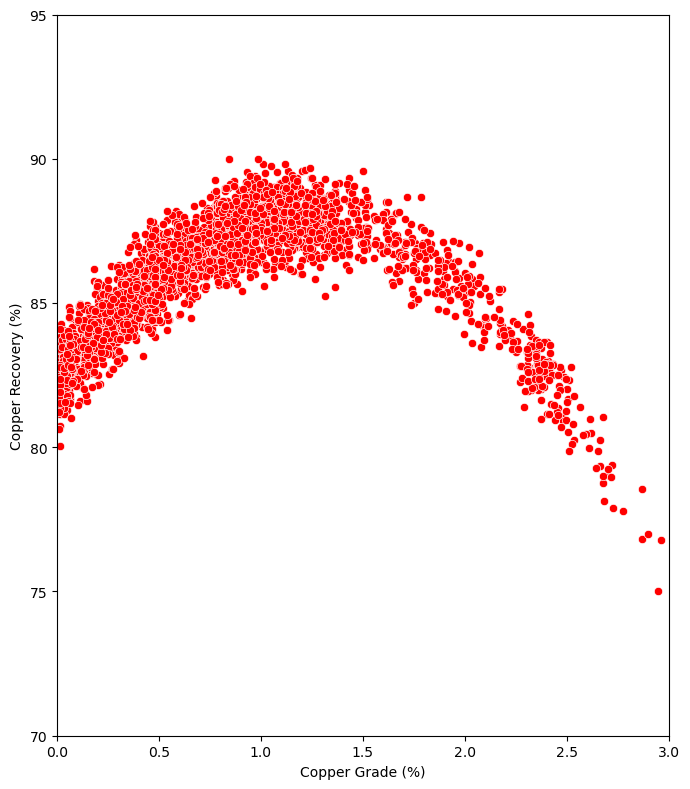

Este escenario es la base de la cual se extraerá la muestra para Z1.


In [157]:
plt.figure(figsize=(7, 8))
sns.scatterplot(data=df, x='Z2', y='Z1_C', color="red")
plt.xlabel('Copper Grade (%)')
plt.ylabel('Copper Recovery (%)')
#plt.title("Relationship in bench")
plt.xlim(0, round(max(df["Z2"]) + 0.5))
plt.ylim(70, 95)
plt.tight_layout()
plt.savefig("scatterplot_z2_z1_full.png", dpi=200)
plt.show()
print("Este escenario es la base de la cual se extraerá la muestra para Z1.")


**3. Visualización 3D variables de interés:**

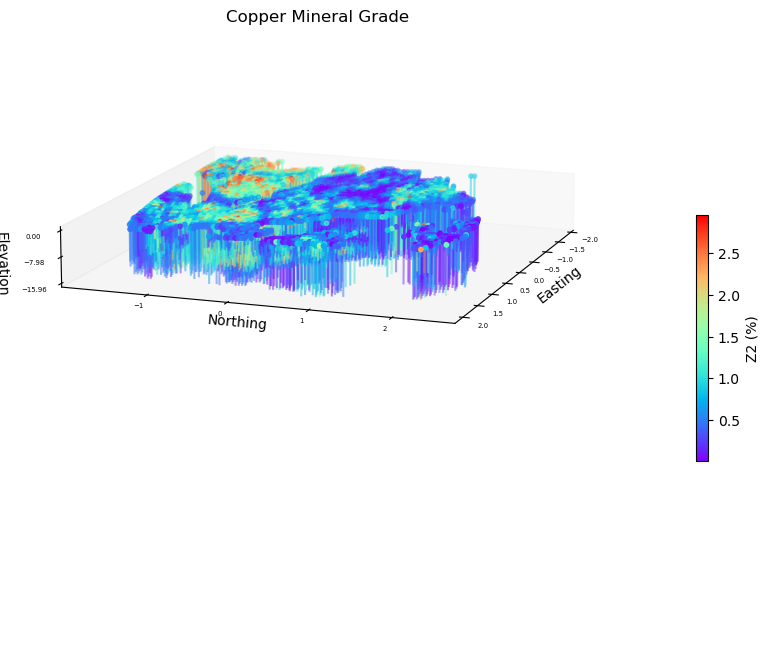

In [103]:
fig = plt.figure(figsize=(18,8))

# Primer gráfico
ax1 = fig.add_subplot(111, projection='3d')
sc1 = ax1.scatter(df['X'], df['Y'], 0, c=df['Z2'], cmap='rainbow', s=10) #la unidad de medida de Z2 es "%"
ax1.set_xlabel('Easting')
ax1.set_ylabel('Northing')
ax1.set_zlabel('Elevation')
for x, y, z, c in zip(df['X'], df['Y'], df['LONG'], df['Z2']):
    ax1.plot([x, x], [y, y], [0, -z], color=sc1.cmap(sc1.norm(c)), alpha=0.5)

ax1.view_init(elev=15, azim=20)
ax1.grid(False)
cb1 = plt.colorbar(sc1, orientation='vertical', ax=ax1, shrink=0.4)
cb1.ax.tick_params(labelsize=10)
cb1.set_label('Z2 (%)')
ax1.set_title('Copper Mineral Grade')

ax1.get_proj = lambda: np.dot(Axes3D.get_proj(ax1), np.diag([1, 1, 0.2, 1]))
ax1.set_zticks(np.linspace(-df['LONG'].max(), 0, 3)) 
ax1.tick_params(axis='x', labelsize=5)
ax1.tick_params(axis='y', labelsize=5)
ax1.tick_params(axis='z', labelsize=5)

plt.show()

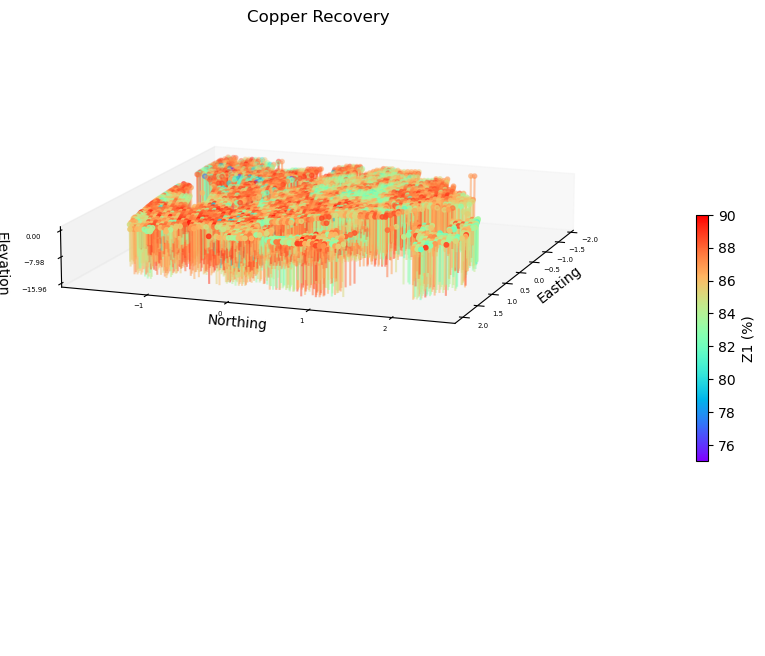

In [104]:
fig = plt.figure(figsize=(18,8))

# Primer gráfico
ax1 = fig.add_subplot(111, projection='3d')
sc1 = ax1.scatter(df['X'], df['Y'], 0, c=df['Z1_C'], cmap='rainbow', s=10) #la unidad de medida de Z2 es "%"
ax1.set_xlabel('Easting')
ax1.set_ylabel('Northing')
ax1.set_zlabel('Elevation')
for x, y, z, c in zip(df['X'], df['Y'], df['LONG'], df['Z1_C']):
    ax1.plot([x, x], [y, y], [0, -z], color=sc1.cmap(sc1.norm(c)), alpha=0.5)

ax1.view_init(elev=15, azim=20)
ax1.grid(False)
cb1 = plt.colorbar(sc1, orientation='vertical', ax=ax1, shrink=0.4)
cb1.ax.tick_params(labelsize=10)
cb1.set_label('Z1 (%)')
ax1.set_title('Copper Recovery')

ax1.get_proj = lambda: np.dot(Axes3D.get_proj(ax1), np.diag([1, 1, 0.2, 1]))
ax1.set_zticks(np.linspace(-df['LONG'].max(), 0, 3)) 
ax1.tick_params(axis='x', labelsize=5)
ax1.tick_params(axis='y', labelsize=5)
ax1.tick_params(axis='z', labelsize=5)

plt.show()

In [105]:
# Calcular los coeficientes de correlación
pearson_corr, _ = scipy.stats.pearsonr(df["Z2"], df["Z1_C"])
spearman_corr, _ = scipy.stats.spearmanr(df["Z2"], df["Z1_C"])
kendall_corr, _ = scipy.stats.kendalltau(df["Z2"], df["Z1_C"])

# Imprimir los coeficientes de correlación
print("Coeficiente de correlación de Pearson:", pearson_corr)
print("Coeficiente de correlación de Spearman:", spearman_corr)
print("Coeficiente de correlación de Kendall:", kendall_corr)

Coeficiente de correlación de Pearson: 0.11882272471910656
Coeficiente de correlación de Spearman: 0.5237174384407633
Coeficiente de correlación de Kendall: 0.43141178148037795


**4. Guardar tablas de datos completa y parcial:** Se muestreara al 5% la variable Z1 y se creara el escenario a trabajar.

Se creara una muestra parcial de las variables dependientes Z1 para la construcción de la copula. Posterior construir el modelo de dependencia con copulas, se compararan las estimaciones con respecto a los valores reales.

In [106]:
df_real = df.copy()
df_real.to_csv("datos_banco_completo.csv", index=False)
indice_max = df_real["Z2"].idxmax()
fila_max = df_real.loc[indice_max].copy()
num_filas_eliminar = int(df['Z1_C'].count() * 0.95) #solo se trabajará con el 10% de los datos para Z1
indices_eliminar = df[['Z1_C']].sample(num_filas_eliminar, random_state=42).index
df_test = df.loc[indices_eliminar]
df_test.to_csv("datos_banco_test.csv", index=False)
df.loc[indices_eliminar, ['Z1_C']] = None
df_train = df.loc[~df.index.isin(indices_eliminar)]
df_train = df_train.append(fila_max, ignore_index=True)
df_train.to_csv("datos_banco_train.csv", index=False)

print("Número total de datos: ", df_real["Z1_C"].count(), "homotópicos")
print("Número de datos para entrenamiento de la copula: ", df_train["Z1_C"].count(), ", (5%)", " Z1 sub-muestreado")
print("Número de datos para la prueba del modelo: ", df_test["Z1_C"].count(), ", (95%)")


Número total de datos:  2961 homotópicos
Número de datos para entrenamiento de la copula:  150 , (5%)  Z1 sub-muestreado
Número de datos para la prueba del modelo:  2812 , (95%)


**5. Datos con dependencia NO LINEAL:** La variable independiente (Z2) debe quedar con la misma cantidad de valores que la sub-muestreada (Z1).

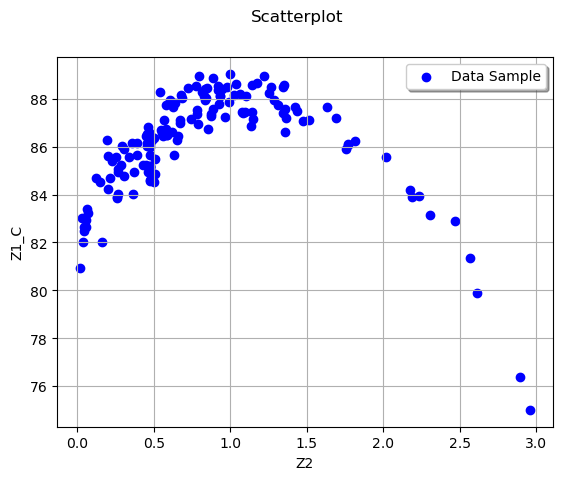

In [107]:
df1 = pd.read_csv("datos_banco_train.csv", sep=",") #Datos homotopicos (conjunto de datos de entrenamiento 20%)

columnas= ['Z2','Z1_C'] #prueba con dependencia NO LINEAL
df1 = df1[columnas]
df = df1.dropna()
sample = ot.Sample(df.values)
sample.setDescription(['Z2', 'Z1_C'])

n_var = sample.getDimension()
sample_size=sample.getSize()
name_var1=sample.getDescription()[0]
name_var2=sample.getDescription()[1]
label_var1=name_var1
label_var2=name_var2
var1=sample[:,0] #VAR1 = Z2 = VARIABLE INDEPENDIENTE
var1.setName(label_var1)
var2=sample[:,1] #VAR2 = Z1 = VARIABLE DEPENDIENTE
var2.setName(label_var2)

cloud_DS = ot.Cloud(sample, "blue", "fcircle","Data Sample")
figure_DS = ot.Graph("Scatterplot", label_var1, label_var2, True, "topright")
figure_DS.add(cloud_DS)
view=otv.View(figure_DS)
view.save("asdas_scatterplot.png",dpi=200)

In [108]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Z2,150.0,0.827233,0.606010,0.01495,0.457470,0.665275,1.093592,2.963090
Z1_C,150.0,86.149083,2.214405,75.00000,85.155791,86.506594,87.715247,89.041356


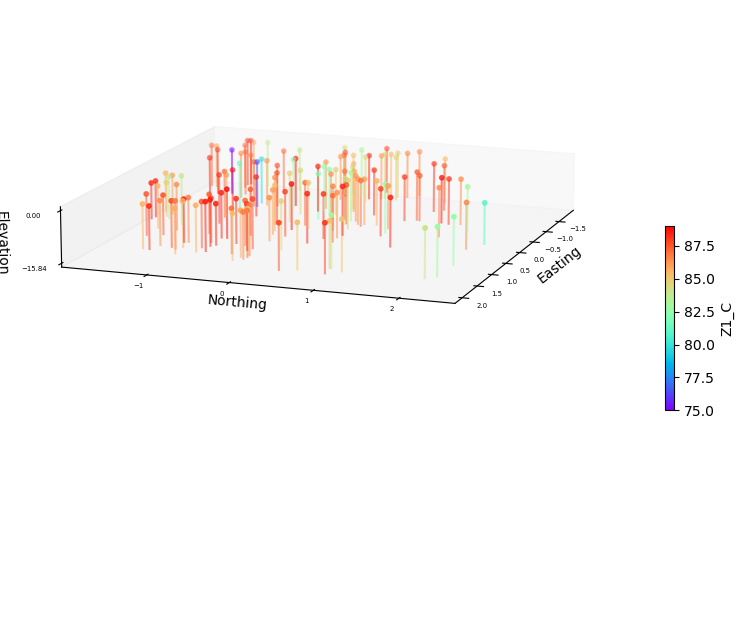

In [109]:
df_train = pd.read_csv("datos_banco_train.csv", sep=",")
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(df_train['X'], df_train['Y'], 0, c=df_train['Z1_C'], cmap='rainbow', s=10) #la unidad de medida de Z2 es "%"
ax.set_xlabel('Easting')
ax.set_ylabel('Northing')
ax.set_zlabel('Elevation')
for x, y, z, c in zip(df_train['X'], df_train['Y'], df_train['LONG'], df_train['Z1_C']):
    ax.plot([x, x], [y, y], [0, -z], color=sc.cmap(sc.norm(c)), alpha=0.5)

ax.view_init(elev=15, azim=20)
ax.grid(False)
cb = plt.colorbar(sc, orientation='vertical', ax=ax, shrink=0.3)
cb.set_label('Z1_C')
cb.ax.tick_params(labelsize=10)

ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1, 1, 0.2, 1]))
ax.set_zticks(np.linspace(-df_train['LONG'].max(), 0, 2)) 
ax.tick_params(axis='x', labelsize=5)
ax.tick_params(axis='y', labelsize=5)
ax.tick_params(axis='z', labelsize=5)

plt.show()

**5.1. Estadísticas univariadas Z2, Z1:**

In [110]:
print("--------------------------------------------------")
print('Summary of Univariate Statistics')
print("--------------------------------------------------")
print('Size=',sample.getSize())
print('Name=',sample.getDescription())
print('Minimum=',sample.getMin())
print('1st quartile=',sample.computeQuantilePerComponent(0.25))
print('Mean=',sample.computeMean())
print('Median=',sample.computeMedian())
print('3rd quartile=',sample.computeQuantilePerComponent(0.75))
print('Maximum=',sample.getMax())
print('Range=',sample.computeRange())
print('Variance=',sample.computeVariance())
print('Standard Deviation=',sample.computeStandardDeviation())
print('Skewness=',sample.computeSkewness())
print('Kurtosis=',sample.computeKurtosis())

--------------------------------------------------
Summary of Univariate Statistics
--------------------------------------------------
Size= 150
Name= [Z2,Z1_C]
Minimum= [0.01495,75]
1st quartile= [0.45747,85.1497]
Mean= [0.827233,86.1491]
Median= [0.665275,86.5066]
3rd quartile= [1.09733,87.731]
Maximum= [2.96309,89.0414]
Range= [2.94814,14.0414]
Variance= [0.367248,4.90359]
Standard Deviation= [0.60601,2.21441]
Skewness= [1.33947,-1.83518]
Kurtosis= [4.87238,8.72283]


**5.2. Estadístivas bivariadas:**

In [111]:
print("--------------------------------------------------")
print('Summary of Bivariate Statistics')
print("--------------------------------------------------")
print('Covariance=',sample.computeCovariance())
print('Standard Deviation=',sample.computeStandardDeviation())
print('Pearson correlation matrix=',sample.computePearsonCorrelation())
print('Kendall correlation matrix=',sample.computeKendallTau())
print('Spearman  correlation matrix=',sample.computeSpearmanCorrelation())
print("--------------------------------------------------")

--------------------------------------------------
Summary of Bivariate Statistics
--------------------------------------------------
Covariance= [[  0.367248 -0.127711 ]
 [ -0.127711  4.90359  ]]
Standard Deviation= [0.60601,2.21441]
Pearson correlation matrix= [[  1         -0.0951678 ]
 [ -0.0951678  1         ]]
Kendall correlation matrix= [[ 1       0.38176 ]
 [ 0.38176 1       ]]
Spearman  correlation matrix= [[ 1        0.473632 ]
 [ 0.473632 1        ]]
--------------------------------------------------


**MODELADO DE CÓPULA NO PARAMÉTRICA CON KERNEL SMOOTHING (KS)**

**6. ESTIMACIÓN DE DISTRIBUCIONES MARGINALES CON KS:**

In [112]:
kernel_distribution=ot.Epanechnikov() #Tipo de KERNEL UTILIZADO

kernel = ot.KernelSmoothing(kernel_distribution)
estimated_kernel_var1= kernel.build(var1) #Z2 = VARIABLE INDEPENDIENTE 
estimated_kernel_var2= kernel.build(var2) #Z1 = VARIABLE DEPENDIENTE 

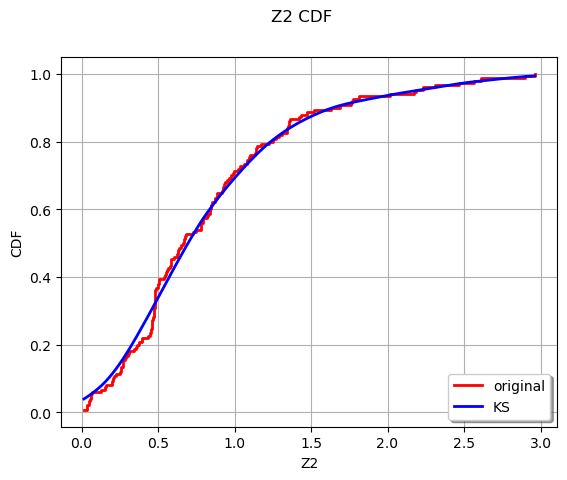

In [113]:
graph = ot.Graph()
graph.setTitle('Kernel smoothing vs original')
xmin = var1.getMin()[0] #var1=sample[:,0] #VAR1 = Z2 = VARIABLE INDEPENDIENTE
xmax = var1.getMax()[0]
graph = ot.UserDefined(var1).drawCDF(xmin, xmax)
#graph.add(distribution.drawCDF())
kernel_plot = estimated_kernel_var1.drawCDF(xmin, xmax).getDrawable(0)
kernel_plot.setColor('blue')
graph.add(kernel_plot)
graph.setLegends(['original', 'KS'])
graph.setLegendPosition('bottomright')
view = otv.View(graph)

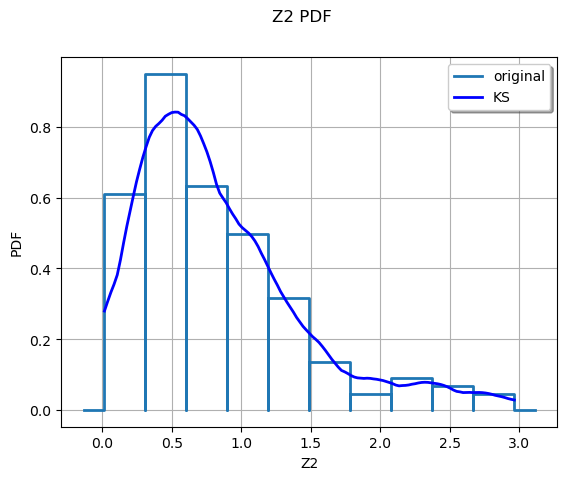

In [114]:
graph1 = ot.Graph()
graph1.setTitle('Kernel smoothing vs original')
graph1 = ot.HistogramFactory().build(var1).drawPDF()
#graph1.add(fit_Normal_distribution_var1.drawPDF())
xmin = var1.getMin()[0] # - 1.0
xmax = var1.getMax()[0] # + 1.0
kernel_plot = estimated_kernel_var1.drawPDF(xmin, xmax).getDrawable(0)
kernel_plot.setColor('blue')
graph1.add(kernel_plot)
graph1.setLegends(['original', 'KS'])
graph1.setLegendPosition('topright')
view = otv.View(graph1)

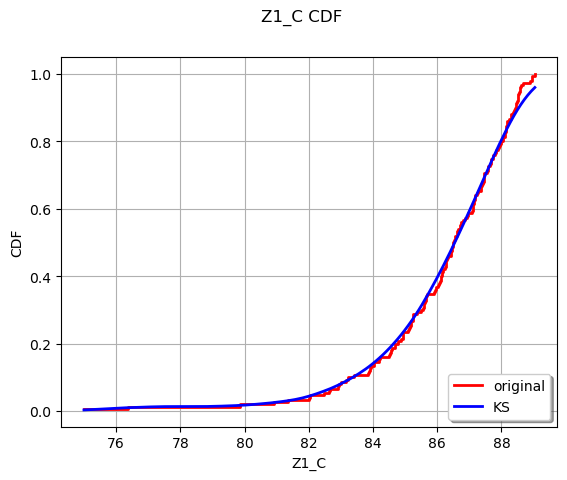

In [115]:
kernel = ot.KernelSmoothing(kernel_distribution)
estimated_kernel_var2 = kernel.build(var2)
# Plot sample vs kernel smoothing (CDF)
graph3 = ot.Graph()
graph3.setTitle('Kernel smoothing vs original')
xmin = var2.getMin()[0] #- 1.0
xmax = var2.getMax()[0] #+ 1.0
graph3 = ot.UserDefined(var2).drawCDF(xmin, xmax)
#graph3.add(distribution.drawCDF())
kernel_plot = estimated_kernel_var2.drawCDF(xmin, xmax).getDrawable(0)
kernel_plot.setColor('blue')
graph3.add(kernel_plot)
graph3.setLegends(['original', 'KS'])
graph3.setLegendPosition('bottomright')
view = otv.View(graph3)

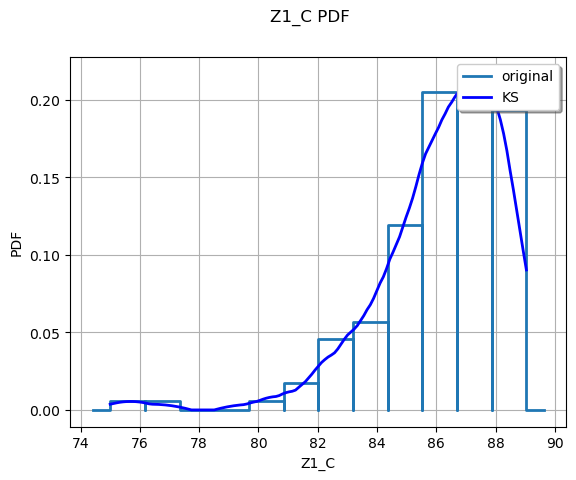

In [116]:
graph2 = ot.Graph()
graph2.setTitle('Kernel smoothing vs original')
graph2 = ot.HistogramFactory().build(var2).drawPDF()
xmin = var2.getMin()[0] # - 1.0
xmax = var2.getMax()[0] # + 1.0
kernel_plot = estimated_kernel_var2.drawPDF(xmin, xmax).getDrawable(0)
kernel_plot.setColor('blue')
graph2.add(kernel_plot)
graph2.setLegends(['original', 'KS'])
graph2.setLegendPosition('topright')
view = otv.View(graph2)
#view.save("", dpi=200)

**7. Ajuste de una cópula no paramétrica utilizando KS:**

In [117]:
KernelSmoothing_copula_distribution = ot.KernelSmoothing(kernel_distribution).build(sample).getCopula()

**8. Construcción de una distribución conjunta a partir de distribuciones marginales y estructura de dependencia:**

In [118]:
KernelSmoothing_bivariate_distribution=ot.ComposedDistribution([estimated_kernel_var1,estimated_kernel_var2], KernelSmoothing_copula_distribution)

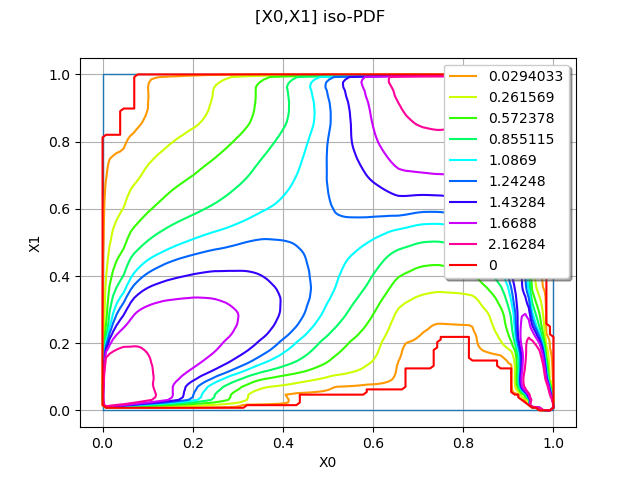

In [119]:
KernelSmoothing_copula_distribution.drawPDF()

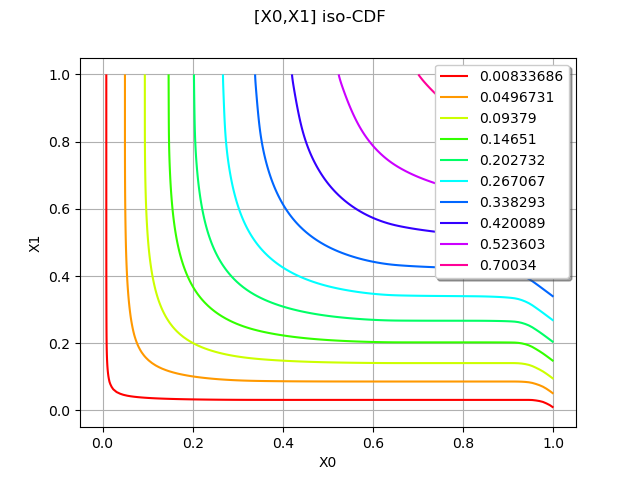

In [120]:
KernelSmoothing_copula_distribution.drawCDF()

**9. Simulaciones de una distribución multivariada paramétrica ajustada.**

In [121]:
simulation_vector=ot.RandomVector(KernelSmoothing_bivariate_distribution)
simulation_size=sample_size
simulation=simulation_vector.getSample(simulation_size)

label_var1_sim=label_var1+'_sim'
label_var2_sim=label_var2+'_sim'
simulation.setDescription([label_var1_sim,label_var2_sim])

**9.1. Estadísticas univariadas Copula ajustada con Kernel Smoothing**

In [122]:
var1_sim=simulation[:,0]
var1_sim.setName(label_var1_sim)

var2_sim=simulation[:,1]
var2_sim.setName(label_var2_sim)

print('Size=',simulation.getSize())
print('Name=',simulation.getDescription())
print('Minimum=',simulation.getMin())
print('1st quartile=',simulation.computeQuantilePerComponent(0.25))
print('Mean=',simulation.computeMean())
print('Median=',simulation.computeMedian())
print('3rd quartile=',simulation.computeQuantilePerComponent(0.75))
print('Maximum=',simulation.getMax())
print('Range=',simulation.computeRange())
print('Variance=',simulation.computeVariance())
print('Standard Deviation=',simulation.computeStandardDeviation())
print('Skewness=',simulation.computeSkewness())
print('Kurtosis=',simulation.computeKurtosis())

Size= 150
Name= [Z2_sim,Z1_C_sim]
Minimum= [-0.129712,74.2208]
1st quartile= [0.399364,85.2618]
Mean= [0.900119,86.1441]
Median= [0.714019,86.4744]
3rd quartile= [1.24216,87.915]
Maximum= [2.90368,90.0025]
Range= [3.03339,15.7817]
Variance= [0.46907,6.53684]
Standard Deviation= [0.684887,2.55672]
Skewness= [1.13582,-1.88093]
Kurtosis= [3.97076,8.47205]


**9.2. Estadísticas bivariadas Copula ajustada con Kernel Smoothing**

In [123]:
print('Covariance=',simulation.computeCovariance())
print('Standard Deviation=',simulation.computeStandardDeviation())
print('Pearson correlation matrix=',simulation.computePearsonCorrelation())
print('Kendall correlation matrix=',simulation.computeKendallTau())
print('Spearman  correlation matrix=',simulation.computeSpearmanCorrelation())
print("--------------------------------------------------")

Covariance= [[  0.46907  -0.461661 ]
 [ -0.461661  6.53684  ]]
Standard Deviation= [0.684887,2.55672]
Pearson correlation matrix= [[  1        -0.263646 ]
 [ -0.263646  1        ]]
Kendall correlation matrix= [[ 1        0.190515 ]
 [ 0.190515 1        ]]
Spearman  correlation matrix= [[ 1        0.239035 ]
 [ 0.239035 1        ]]
--------------------------------------------------


**9.3. Visualización de muestra versus Simulación:**

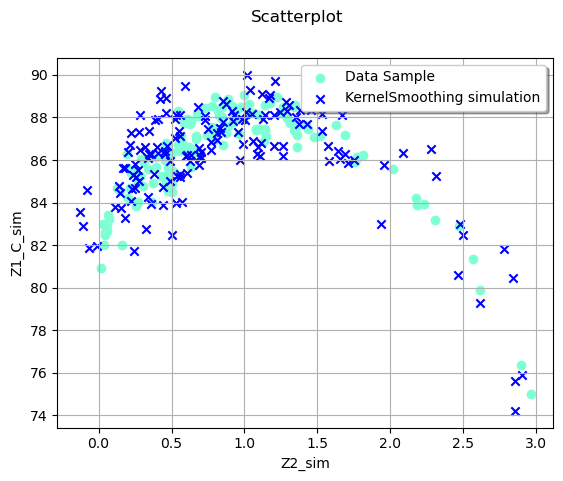

In [124]:
cloud_DS = ot.Cloud(sample, 'aquamarine1', 'fcircle', 'Data Sample')
cloud_KS = ot.Cloud(simulation, 'blue', 'times', 'KernelSmoothing simulation')
figure_KS = ot.Graph("Scatterplot", label_var1_sim, label_var2_sim, True, 'topright')
figure_KS.add(cloud_DS)
figure_KS.add(cloud_KS)
view = otv.View(figure_KS)
#view.save("", dpi=200)

In [125]:
#Utilidades de hacer Simulación:

#1. Generación de datos sintéticos: Puedes utilizar la simulación para generar datos sintéticos que sigan el modelo de dependencia que has establecido. Esto puede ser útil para realizar análisis de sensibilidad, pruebas de hipótesis o simplemente para tener datos adicionales para trabajar.

#2. Estimación de probabilidades conjuntas: Con la simulación, puedes estimar la probabilidad conjunta de ciertos eventos que involucren ambas variables var1 y var2, lo cual puede ser útil en análisis de riesgo o toma de decisiones.

#3. Validación del modelo: La simulación te permite verificar si el modelo de dependencia que has establecido se ajusta correctamente a tus datos observados. Puedes comparar estadísticas de la muestra simulada con las de tu muestra original para evaluar la calidad del ajuste del modelo.

**9.4. Nube en el espacio del Rango:** Al transformar las marginales a rangos, se elimina la distribución marginal de las variables, lo que es útil para enfocarse exclusivamente en la estructura de dependencia entre las variables.

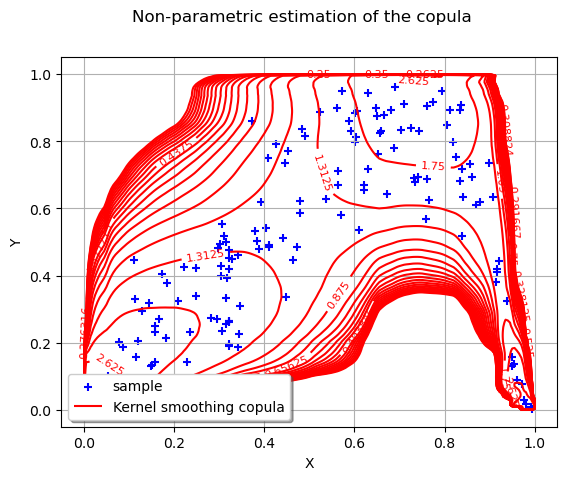

In [126]:
ranksTransf = ot.MarginalTransformationEvaluation([estimated_kernel_var1,estimated_kernel_var2], ot.MarginalTransformationEvaluation.FROM)
rankSample = ranksTransf(sample)
rankCloud = ot.Cloud(rankSample, 'blue', 'plus', 'sample')
# Graph with rank sample and estimated copula
myGraph_KS = ot.Graph('Non-parametric estimation of the copula', 'X', 'Y', True, 'topleft')
myGraph_KS.setLegendPosition('bottomleft')
myGraph_KS.add(rankCloud)
# Then draw the iso-curves of the estimated copula
minPoint = [0.0]*2
maxPoint = [1.0]*2
pointNumber = [201]*2
graphCop = KernelSmoothing_copula_distribution.drawPDF(minPoint, maxPoint, pointNumber)
contour_estCop = graphCop.getDrawable(0)
# Erase the labels of the iso-curves
contour_estCop.setDrawLabels(False)
# Change the levels of the iso-curves
nlev = 21
levels = ot.Point(nlev)
for i in range(nlev):
    levels[i] = 0.25 * nlev / (nlev - i)
contour_estCop.setLevels(levels)
# Change the legend of the curves
contour_estCop.setLegend('Kernel smoothing copula')
# Change the color of the iso-curves
contour_estCop.setColor('red')
contour_estCop.setDrawLabels(True)
# Add the iso-curves graph into the cloud one
myGraph_KS.add(contour_estCop)
view = otv.View(myGraph_KS)
#view.save("", dpi=200)

**9.5. Diagrama de dispersión:** Valores estimados versus reales de Z2 (Recuperación de Cobre)

Size= 150
Name= [Z1_C]
Minimum= [-3.16254]
1st quartile= [-0.653115]
Mean= [-0.125584]
Median= [-0.0410152]
3rd quartile= [0.463169]
Maximum= [1.92359]
Range= [5.08614]
Variance= [0.748277]
Standard Deviation= [0.86503]
Skewness= [-0.571434]
Kurtosis= [3.7347]


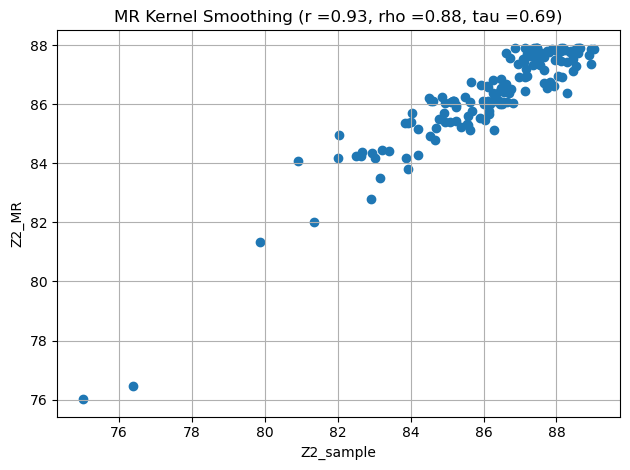

In [127]:
xobs = np.linspace(0, 3, sample_size)

x = [xi for xi in xobs]
yapp_Q1 = [KernelSmoothing_bivariate_distribution.computeConditionalQuantile(0.25, var1[i]) for i in range(sample_size)]
yapp_Q3 = [KernelSmoothing_bivariate_distribution.computeConditionalQuantile(0.75, var1[i]) for i in range(sample_size)]
yapp_Q2 = [KernelSmoothing_bivariate_distribution.computeConditionalQuantile(0.5, var1[i]) for i in range(sample_size)]

Point_yapp_Q1=ot.Point(yapp_Q1)
Point_yapp_Q2=ot.Point(yapp_Q2)
Point_yapp_Q3=ot.Point(yapp_Q3)

Sample_yapp=ot.Sample([Point_yapp_Q1, Point_yapp_Q2, Point_yapp_Q3])

array_yapp = np.array(Sample_yapp)

sample_yapp_Q1 = ot.Sample([[ui] for ui in array_yapp[0,:]])
sample_yapp_Q2 = ot.Sample([[ui] for ui in array_yapp[1,:]])
sample_yapp_Q3 = ot.Sample([[ui] for ui in array_yapp[2,:]])

error_yapp_Q2=var2-sample_yapp_Q2
error_yapp_IQR=sample_yapp_Q3-sample_yapp_Q1

print('Size=',error_yapp_Q2.getSize())
print('Name=',error_yapp_Q2.getDescription())
print('Minimum=',error_yapp_Q2.getMin())
print('1st quartile=',error_yapp_Q2.computeQuantilePerComponent(0.25))
print('Mean=',error_yapp_Q2.computeMean())
print('Median=',error_yapp_Q2.computeMedian())
print('3rd quartile=',error_yapp_Q2.computeQuantilePerComponent(0.75))
print('Maximum=',error_yapp_Q2.getMax())
print('Range=',error_yapp_Q2.computeRange())
print('Variance=',error_yapp_Q2.computeVariance())
print('Standard Deviation=',error_yapp_Q2.computeStandardDeviation())
print('Skewness=',error_yapp_Q2.computeSkewness())
print('Kurtosis=',error_yapp_Q2.computeKurtosis())

Sample_yapp_Q1=ot.Sample([Point_yapp_Q1])
array_yapp_Q1 = np.array(Sample_yapp_Q1)
Sample_yapp_Q2=ot.Sample([Point_yapp_Q2])
array_yapp_Q2 = np.array(Sample_yapp_Q2)
Sample_yapp_Q3=ot.Sample([Point_yapp_Q3])
array_yapp_Q3 = np.array(Sample_yapp_Q3)
array_var2 = np.array(var2)
x=array_var2[:,0]
y=array_yapp_Q2[0,:]
xmin=np.min(x)
xmax=np.max(x)
ymin=np.min(y)
ymax=np.max(y)
xlab='Z2_sample'
ylab='Z2_MR'
pearson = np.corrcoef(x, y)[0,1]
spearman, p = scipy.stats.spearmanr(x, y)
kendall, p = scipy.stats.kendalltau(x, y)
#spearman = kendall
title='MR Kernel Smoothing (r ='+ "{:4.2f}".format(pearson) +', rho ='+ "{:4.2f}".format(spearman) +', tau ='+ "{:4.2f}".format(kendall) +')'

fig, ax = plt.subplots()
ax.scatter(x, y)
ax.set_xlabel(xlab)
ax.set_ylabel(ylab)
ax.set_title(title)
ax.grid(True)
fig.tight_layout()
plt.show()
#plt.savefig()

In [128]:
df=pd.DataFrame()
df['Z1_REAL'] = array_var2[:,0].tolist()
df['Z1_MR'] = array_yapp_Q2[0,:].tolist()
df['Z1_Q1'] = array_yapp_Q1[0,:].tolist()
df['Z1_Q3'] = array_yapp_Q3[0,:].tolist()

In [129]:
df.head()

,Z1_REAL,Z1_MR,Z1_Q1,Z1_Q3
0,82.490066,84.244203,82.959601,85.404167
1,82.928250,84.346600,83.040294,85.491758
2,84.021552,85.395199,84.261467,86.364621
3,86.499510,86.545623,85.502339,87.593570
4,80.914699,84.077242,82.829214,85.266699


In [130]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Z1_REAL,150.0,86.149083,2.214405,75.000000,85.155791,86.506594,87.715247,89.041356
Z1_MR,150.0,86.274667,1.746525,76.021664,85.622882,86.483859,87.598909,87.902951
Z1_Q1,150.0,85.291952,1.894909,75.209332,84.559377,85.458803,86.754648,87.208163
Z1_Q3,150.0,87.201042,1.531007,77.230409,86.600843,87.461010,88.318435,88.540112


In [131]:
df.to_csv("resultados_punto9.csv")

**10.ENFOQUE: ESTIMACIÓN:** Regresión Mediana con Kernel Smoothing

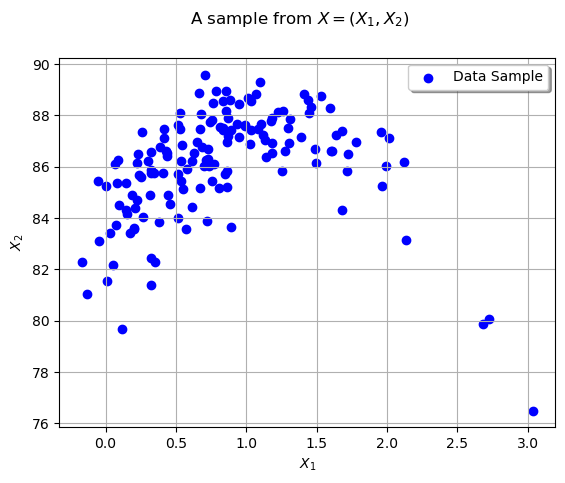

In [132]:
#Modelo de Copula

distX=ot.ComposedDistribution([estimated_kernel_var1,estimated_kernel_var2], KernelSmoothing_copula_distribution)

#Muestra del modelo de copula

sample = distX.getSample(len(sample))

kernel = ot.KernelSmoothing(kernel_distribution) #Estimación 
estimated=kernel.build(sample) #Estimación

graph = ot.Graph("Scatterplot", label_var1, label_var2, True, "topright")
cloud = ot.Cloud(sample, "blue", "fcircle","Data Sample")
graph.add(cloud)
graph.setXTitle("$X_1$")
graph.setYTitle("$X_2$")
graph.setTitle("A sample from $X=(X_1, X_2)$")
view=otv.View(graph)
view.save("222_scatterplot.png",dpi=200)

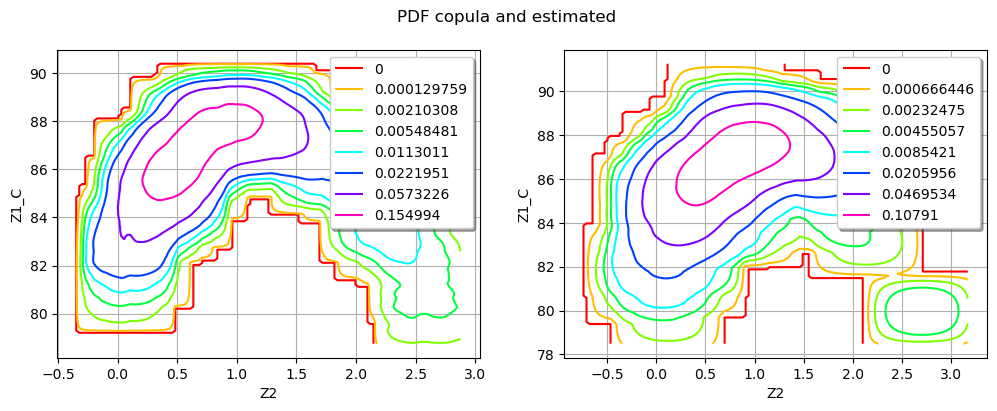

In [133]:
fig = plt.figure(figsize=(12, 4))
ax_pdf = fig.add_subplot(1, 2, 1)
_ = otv.View(distX.drawPDF(), figure=fig, axes=[ax_pdf])

ax_cdf = fig.add_subplot(1, 2, 2)
_ = otv.View(estimated.drawPDF(), figure=fig, axes=[ax_cdf])
_ = fig.suptitle("PDF copula and estimated")

**Estimación de cuantil condicional:**

In [134]:
N = sample_size
xobs = np.linspace(0, 3, N)
sampleObs = ot.Sample([[xi] for xi in xobs])

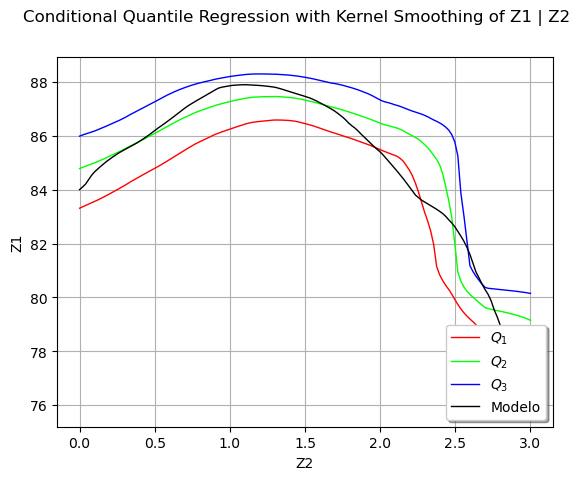

In [135]:
x = [xi for xi in xobs]
#yapp = [estimated.computeConditionalQuantile(0.5, sampleObs[i]) for i in range(N)] #mediana
yex = [distX.computeConditionalQuantile(0.5, sampleObs[i]) for i in range(N)] #mediana modelo (REAL?)

yapp_Q1 = [estimated.computeConditionalQuantile(0.25, sampleObs[i]) for i in range(N)] #Estimación de la copula
yapp_Q2 = [estimated.computeConditionalQuantile(0.50, sampleObs[i]) for i in range(N)] #Estimación de la copula
yapp_Q3 = [estimated.computeConditionalQuantile(0.75, sampleObs[i]) for i in range(N)] #Estimación de la copula

cxy_app_Q1 = ot.Curve(x,yapp_Q1)
cxy_app_Q2 = ot.Curve(x,yapp_Q2)
cxy_app_Q3 = ot.Curve(x,yapp_Q3)
cxy_yex = ot.Curve(x,yex)


graph_ = ot.Graph('Conditional Quantile Regression with Kernel Smoothing of Z1 | Z2', 'Z2', 'Z1', True, '')
graph_.add(cxy_app_Q1)
graph_.add(cxy_app_Q2)
graph_.add(cxy_app_Q3)
graph_.add(cxy_yex)
#graph.add(cxy_ex)
graph_.setLegends(["$Q_1$", "$Q_2$", "$Q_3$", "Modelo"])
graph_.setLegendPosition('bottomright')
graph_.setColors(["red", "green", "blue", "black"])
view = otv.View(graph_)
plt.show()

**Estimación en datos de prueba:** Acá se estima con el modelo de copula con los valores de Z2 conocidos (ver PUNTO 3).

In [136]:
df2 = pd.read_csv("datos_banco_test.csv", sep=",")

columnas= ["Z2","Z1_C"]
df3 = df2[columnas]
df4 = df3.dropna()
df4.head()

,Z2,Z1_C
0,1.59666,85.596757
1,2.53552,81.127275
2,0.47840,85.156081
3,0.78039,86.737117
4,0.96278,87.866480


In [137]:
z2 = np.array(df4["Z2"])
N = len(df4["Z2"]) #número de datos
xobs = z2 #observaciones conocidas de Z2
sampleObs2 = ot.Sample([[xi] for xi in xobs]) #muestra de Z2

In [138]:
x = [xi for xi in xobs]
yapp = [estimated.computeConditionalQuantile(0.50, sampleObs2[i]) for i in range(N)] #Estimación de la copula
yapp3 = [estimated.computeConditionalQuantile(0.750, sampleObs2[i]) for i in range(N)] #Estimación de la copula
yapp1 = [estimated.computeConditionalQuantile(0.250, sampleObs2[i]) for i in range(N)] #Estimación de la copula

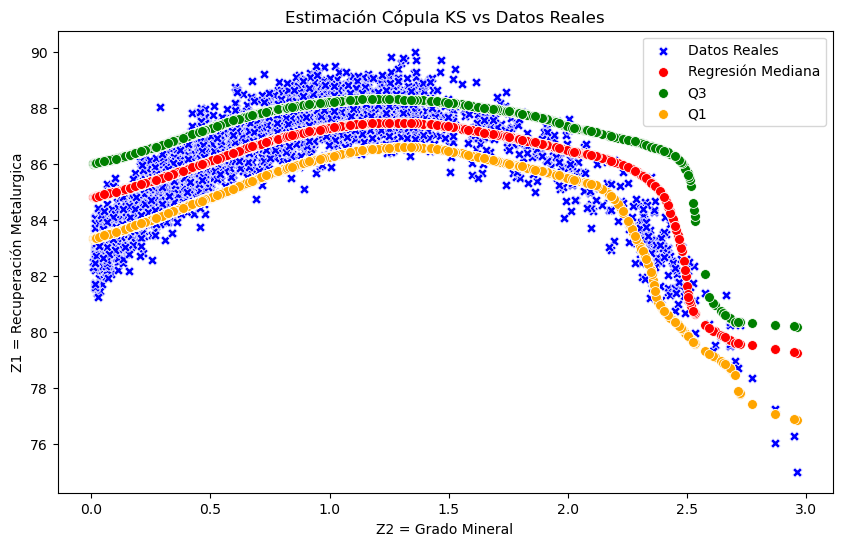

In [139]:
data_estimacion = pd.DataFrame({'Z2': z2, 'Z1_C': yapp})
data_estimacion2 = pd.DataFrame({'Z2': z2, 'Z1_C': yapp3})
data_estimacion3 = pd.DataFrame({'Z2': z2, 'Z1_C': yapp1})

data_real = df4[['Z2', 'Z1_C']]

plt.figure(figsize=(10, 6))

sns.scatterplot(data=data_real, x='Z2', y='Z1_C', color='blue', label='Datos Reales', s=50, marker="X")  # Ajustar el tamaño con s=

sns.scatterplot(data=data_estimacion, x='Z2', y='Z1_C', color='red', label='Regresión Mediana', s=50)  # Ajustar el tamaño con s=
sns.scatterplot(data=data_estimacion2, x='Z2', y='Z1_C', color='green', label='Q3', s=50)  # Ajustar el tamaño con s=
sns.scatterplot(data=data_estimacion3, x='Z2', y='Z1_C', color='orange', label='Q1', s=50)  # Ajustar el tamaño con s=

plt.xlabel('Z2 = Grado Mineral')
plt.ylabel('Z1 = Recuperación Metalurgica')
plt.title('Estimación Cópula KS vs Datos Reales')
plt.legend()

plt.show()
